In [1]:
from swat import CAS
from dlpy.utils import *
from dlpy.applications import *
from dlpy.model import *
from dlpy.images import *
from dlpy.lr_scheduler import *
from dlpy.splitting import two_way_split
import cv2

## Connect to SAS Viya Environment

In [2]:
s = CAS('localhost', 5570, 'sas', 'Orion123')

## Load Images and their labels - Visualize training data
This function creates a ready-to-train image table including all images and the corresponding object labels.

In [3]:
object_detection_targets = create_object_detection_table(conn=s,
                                                         data_path='/data/notebooks/deep_learning_examples/Social Distancing Demo/training_images/',
                                                         local_path='/data/notebooks/deep_learning_examples/Social Distancing Demo/training_images/',
                                                         coord_type='yolo', 
                                                         output='detTbl', 
                                                         image_size=(416,416))
object_detection_targets.insert(0, '_nObjects_')

NOTE: Images are loaded and processed.
NOTE: Object detection table is successfully created.


In [4]:
# Object detection targets = _nObjects_ + 5 variables per object (label,x,y,width,height)
object_detection_targets[0:11]

['_nObjects_',
 '_Object0_',
 '_Object0_x',
 '_Object0_y',
 '_Object0_width',
 '_Object0_height',
 '_Object1_',
 '_Object1_x',
 '_Object1_y',
 '_Object1_width',
 '_Object1_height']

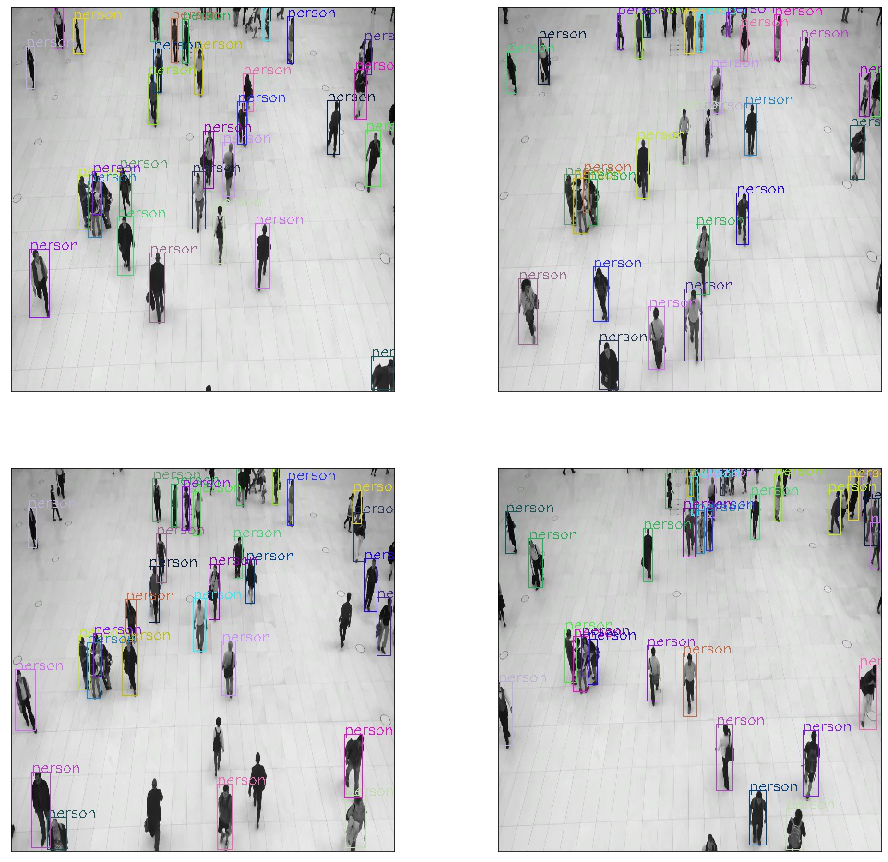

In [5]:
display_object_detections(conn=s, 
                          table=dict(name='detTbl', where='_nObjects_ > 0'), 
                          coord_type='yolo', 
                          max_objects=30, 
                          num_plot=4,
                          n_col=2)

## Split data into training and validation data

In [6]:
sampled_data = s.sampling.srs(table=dict(name='detTbl', where='_nObjects_ > 0'), samppct=90, samppct2=10, partind=True, output=dict(casout=dict(name='sampled_data', replace=True), copyvars='all', partindname='Partind')).OutputCasTables['casTable'][0]
trainData = sampled_data[sampled_data['Partind'] == 1]
validData = sampled_data[sampled_data['Partind'] == 2]

NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=852593737 for sampling.


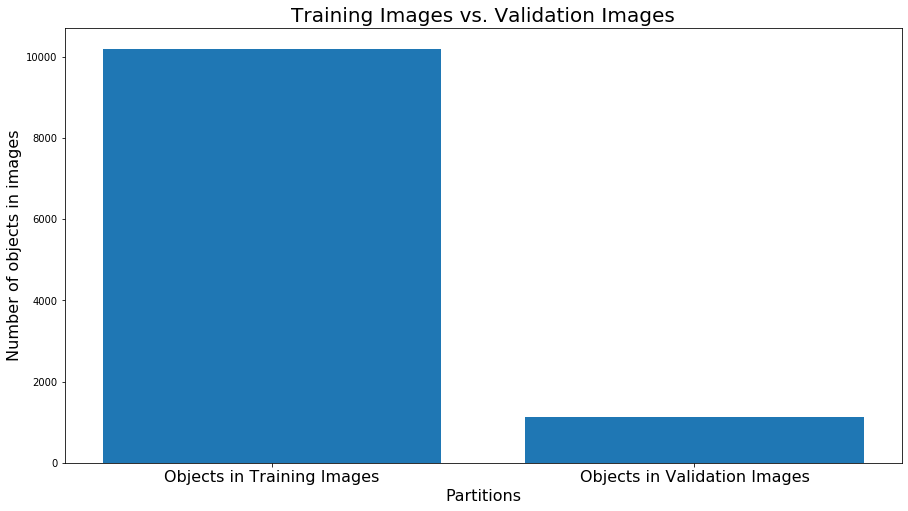

In [7]:
plt.figure(figsize = (15,8))
plt.bar(x=['Objects in Training Images', 'Objects in Validation Images'], height=[get_info_for_object_detection(s, table=trainData)[0]['person'],get_info_for_object_detection(s, table=validData)[0]['person']])
plt.ylabel('Number of objects in images', fontsize=16)
plt.xlabel('Partitions', fontsize=16)
plt.xticks(rotation=0, fontsize=16)
plt.title('Training Images vs. Validation Images', fontsize=20)
plt.show()

# Model Setup
### The following step will be performed to setup the YOLOv2 model:
1. Create Anchors for YOLOv2 model using KMeans-Clustering (optional: check visually if anchors capture object ratios)
2. Use pre-built YOLOv2 architecture with customized parameters (n_classes, n_anchors, predictions_per_grid, etc.)
3. Load pretrained weights
4. Define data_specs (model-inputs & model-target)
5. Define Learning-Rate scheduler, Solver and Optimizer
6. Start Training

In [8]:
yolo_anchors = get_anchors(conn=s, 
                           data=trainData, 
                           n_anchors=15, 
                           coord_type='yolo')
yolo_anchors

(0.5495686120404824,
 2.2241015925997902,
 0.4543816431710084,
 1.7303708350439129,
 0.1760719591875836,
 0.8860770398264212,
 0.30917769512607823,
 1.4639079290271897,
 0.6543966157536969,
 1.2695004848528715,
 0.26874667076919523,
 1.1937451885879502,
 0.3554961961483725,
 1.2543298171719224,
 0.39371756116316636,
 1.525311663134123,
 0.3985171437465176,
 1.818868245704625,
 0.2593961869057489,
 1.5133533613393138,
 0.34952113198052837,
 1.603824757853445,
 0.45566483757594056,
 2.0254745886011287,
 0.5288063028293587,
 1.9215026095132273,
 0.6478283004141512,
 2.3400440062813583,
 0.7026119445540266,
 1.9823092132675293)

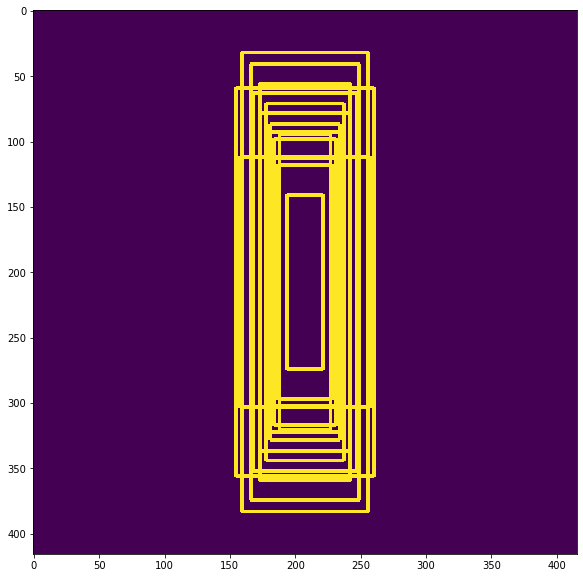

In [9]:
def plot_yolo_anchors(yolo_anchors, image_size, anchor_scale):
    anchor_image = np.zeros(image_size, np.int16)
    yolo_anchors = [yolo_anchors[ix:ix+2] for ix, _ in enumerate(yolo_anchors) if ix%2==0]
    x0,y0 = image_size[0]/2, image_size[1]/2
    for anchor in yolo_anchors:
        x1 = x0-anchor[0]/2*anchor_scale
        y1 = y0-anchor[1]/2*anchor_scale
        x2 = x0+anchor[0]/2*anchor_scale
        y2 = y0+anchor[1]/2*anchor_scale
        cv2.rectangle(anchor_image, (int(x1),int(y1)), (int(x2),int(y2)), (255,0,0), 2)
    plt.figure(figsize = (20,10))
    plt.imshow(anchor_image)
plot_yolo_anchors(yolo_anchors, image_size=(416,416), anchor_scale=150)

In [10]:
yolo_model = Tiny_YoloV2(conn=s, 
                         n_classes=1, 
                         predictions_per_grid=15, 
                         anchors = yolo_anchors,
                         max_boxes=845, 
                         coord_type='yolo',
                         max_label_per_image = 41,
                         class_scale=1.0, 
                         coord_scale=1.0, 
                         prediction_not_a_object_scale=1, 
                         object_scale=5,
                         detection_threshold=0.2, 
                         iou_threshold=0.2, 
                         width=416, 
                         height=416, 
                         grid_number=13)

NOTE: Input layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Convolution layer added.
NOTE: Detection layer added.
NOTE: Model compiled successfully.


In [11]:
yolo_model.load_weights(path='/data/notebooks/deep_learning_examples/models/object_detection/tiny_yolov2_313cls/Tiny-Yolov2_weights.sashdat')

NOTE: Model weights attached successfully!


In [12]:
data_specs = [DataSpec(type_='IMAGE', layer='Input1', data=['_image_']),
              DataSpec(type_='OBJECTDETECTION', layer='Detection1', data=object_detection_targets)]

In [14]:
lr_scheduler = ReduceLROnPlateau(conn=s, 
                                 cool_down_iters=5, 
                                 gamma=0.1, 
                                 learning_rate=0.001, 
                                 patience=5)
solver = MomentumSolver(momentum=0.9, 
                        lr_scheduler=lr_scheduler, 
                        clip_grad_max=100, 
                        clip_grad_min=-100)
optimizer = Optimizer(algorithm=solver, 
                      mini_batch_size=1, 
                      log_level=2, 
                      max_epochs=400, 
                      reg_l2=0.0005,
                      stagnation=50)
gpu = Gpu(devices=[0])

The following argument(s) learning_rate, gamma, step_size, power are overwritten by the according arguments specified in lr_scheduler.


In [15]:
# Start Training
yolo_model.fit(data=trainData,
               valid_table=validData,
               optimizer=optimizer,
               data_specs=data_specs, 
               n_threads=1, 
               record_seed=54321,
               force_equal_padding=True, 
               gpu=gpu,
               save_best_weights=True)

NOTE: Training based on existing weights.
NOTE: Using michael-AERO-15-X9: 1 out of 1 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 11060112.
NOTE:  The approximate memory cost is 342.00 MB.
NOTE:  Loading weights cost       0.29 (s).
NOTE:  Initializing each layer cost       3.90 (s).
NOTE:  The total number of threads on each worker is 1.
NOTE:  The total mini-batch size per thread on each worker is 1.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 1.
NOTE:  Number of levels for the target variable:      1
NOTE:  Levels for the target variable:
NOTE:  Level      0: person  
NOTE:  Epoch Learning Rate        Loss        IOU  Validation Loss   Validation IOU   Time(s)
NOTE:  0         0.001           759.6     0.2595            177.8           0.2845     4.89
NOTE:  1         0.001           172.6      0.298            171.4           0.2994     3.59
NOTE:  2         0.001           173.4     0.3004

[ModelInfo]

                                         Descr                         Value
 0                                  Model Name                   tiny-yolov2
 1                                  Model Type  Convolutional Neural Network
 2                            Number of Layers                            25
 3                      Number of Input Layers                             1
 4                     Number of Output Layers                             0
 5              Number of Convolutional Layers                             9
 6                    Number of Pooling Layers                             6
 7            Number of Fully Connected Layers                             0
 8        Number of Batch Normalization Layers                             8
 9                  Number of Detection Layers                             1
 10                Number of Weight Parameters                      11055024
 11                  Number of Bias Parameters                          5088
 12           Total Number of Model Parameters                      11060112
 13  Approximate Memory Cost for Training (MB)                           344

[OptIterHistory]

      Epoch  LearningRate        Loss  FitError     L2Norm   ValidLoss  \
 0        1  1.000000e-03  759.583978  0.740505  31.356284  177.780547   
 1        2  1.000000e-03  172.640066  0.702006  33.017113  171.360317   
 2        3  1.000000e-03  173.436795  0.699559  32.813797  170.890296   
 3        4  1.000000e-03  170.179264  0.688578  32.612332  170.516351   
 4        5  1.000000e-03  170.989782  0.683582  32.412272  170.468517   
 ..     ...           ...         ...       ...        ...         ...   
 395    396  1.000000e-27    3.794499  0.189559  15.122657   13.607165   
 396    397  1.000000e-27    3.427558  0.187361  15.122657   13.752171   
 397    398  1.000000e-27    3.607367  0.190566  15.122657   13.374057   
 398    399  1.000000e-27    3.282895  0.188540  15.122657   13.370411   
 399    400  1.000000e-27    3.283623  0.189037  15.122657   13.481358   
 
      ValidError  
 0      0.715451  
 1      0.700586  
 2      0.699034  
 3      0.694199  
 4      0.693501  
 ..          ...  
 395    0.302414  
 396    0.301628  
 397    0.300771  
 398    0.301465  
 399    0.300203  
 
 [400 rows x 7 columns]

[OutputCasTables]

          casLib                       Name      Rows  Columns  \
 0  CASUSER(sas)  model_best_weights_btx1SK  11065200        3   
 1  CASUSER(sas)        Tiny-Yolov2_weights  11065200        3   
 
                                             casTable  
 0  CASTable('model_best_weights_btx1SK', caslib='...  
 1  CASTable('Tiny-Yolov2_weights', caslib='CASUSE...  

+ Elapsed: 1.43e+03s, user: 1.97e+03s, sys: 10.8s, mem: 385mb

## Verify Model Training
Validation Loss should decrease over time. If Validation Loss increases - the model might be overfitting the data.<br>
Additionally we can score our validation images with the trained model and visually verify the correctness of its predictions for some images.<br>
In the last step we plot some object-detection measures, e.g. mean average percentage.

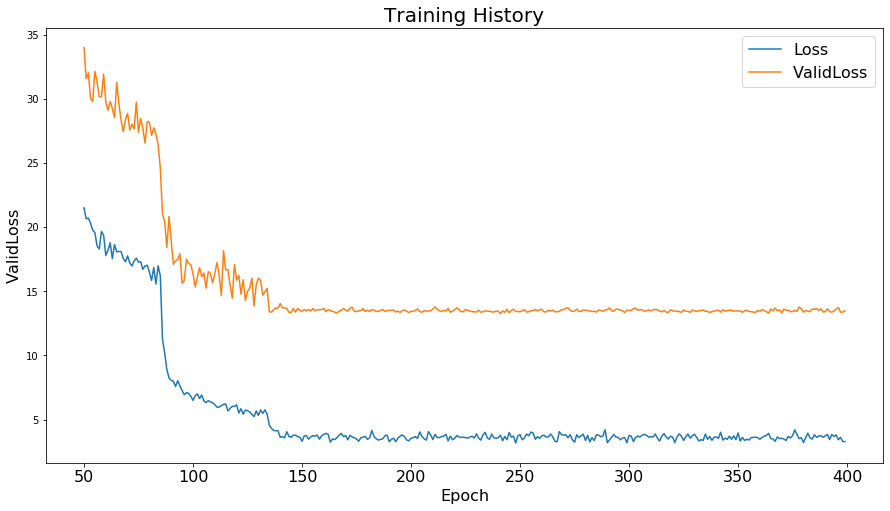

In [19]:
plt.figure(figsize = (15,8))
plt.plot(yolo_model.training_history.tail(350)[['Loss','ValidLoss']])
plt.ylabel('ValidLoss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.xticks(fontsize=16)
plt.title('Training History', fontsize=20)
plt.legend(['Loss','ValidLoss'], fontsize=16)
plt.show()

### Set Model weights to the best weights achieved during training and score validation data

In [20]:
yolo_model.set_weights(yolo_model.best_weights)

NOTE: Model weights attached successfully!


In [21]:
yolo_model.predict(data=validData, gpu=gpu)

NOTE: Due to data distribution, miniBatchSize has been limited to 5.
NOTE: Using michael-AERO-15-X9: 1 out of 1 available GPU devices.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read            34
 1  Number of Observations Used            34
 2     Average IoU in Detection      0.699176
 3                   Loss Error      19.06021

[OutputCasTables]

          casLib              Name  Rows  Columns  \
 0  CASUSER(sas)  Valid_Res_kF5vnN    34    15215   
 
                                             casTable  
 0  CASTable('Valid_Res_kF5vnN', caslib='CASUSER(s...  

+ Elapsed: 3.34s, user: 2.01s, sys: 0.328s, mem: 552mb

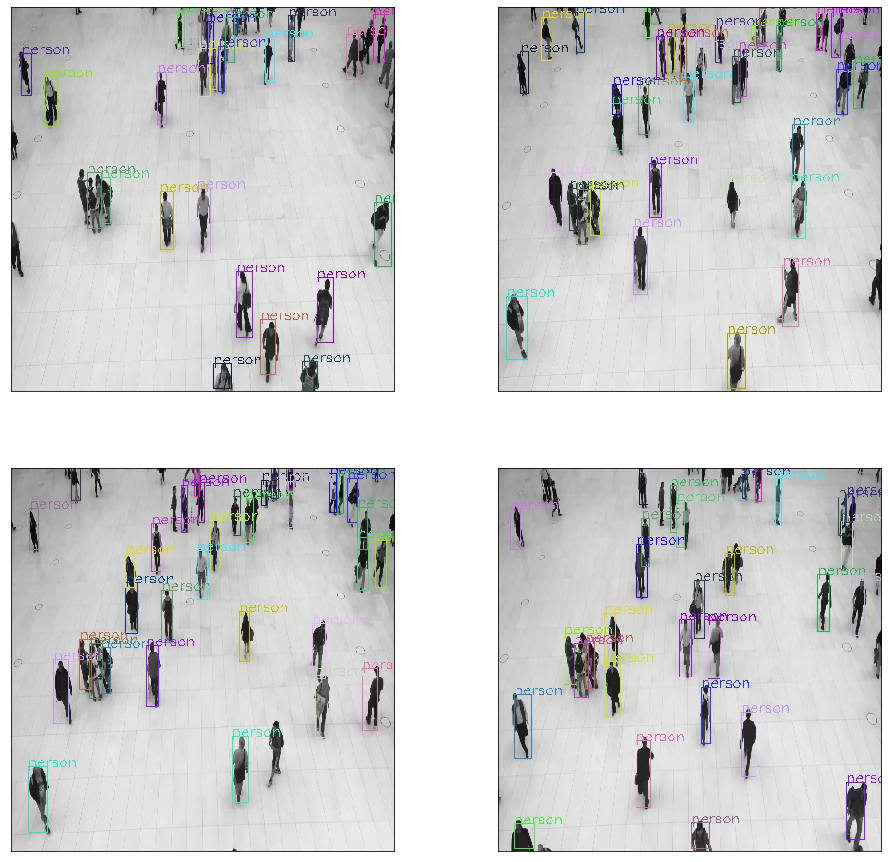

In [22]:
display_object_detections(conn=s, 
                          table=yolo_model.valid_res_tbl, 
                          coord_type='yolo', 
                          max_objects=100, 
                          num_plot=4,
                          n_col=2)

### Assess model performance on validation data

In [23]:
evaluations = yolo_model.evaluate_object_detection(ground_truth=validData, coord_type='yolo', iou_thresholds=[0.55,0.60,0.65,0.70,0.85,0.90,0.95])

Evaluating class: person (1010 detections)
Evaluating class: person (1010 detections)
Evaluating class: person (1010 detections)
Evaluating class: person (1010 detections)
Evaluating class: person (1010 detections)
Evaluating class: person (1010 detections)
Evaluating class: person (1010 detections)


(['person'], [0.018181818181818184])

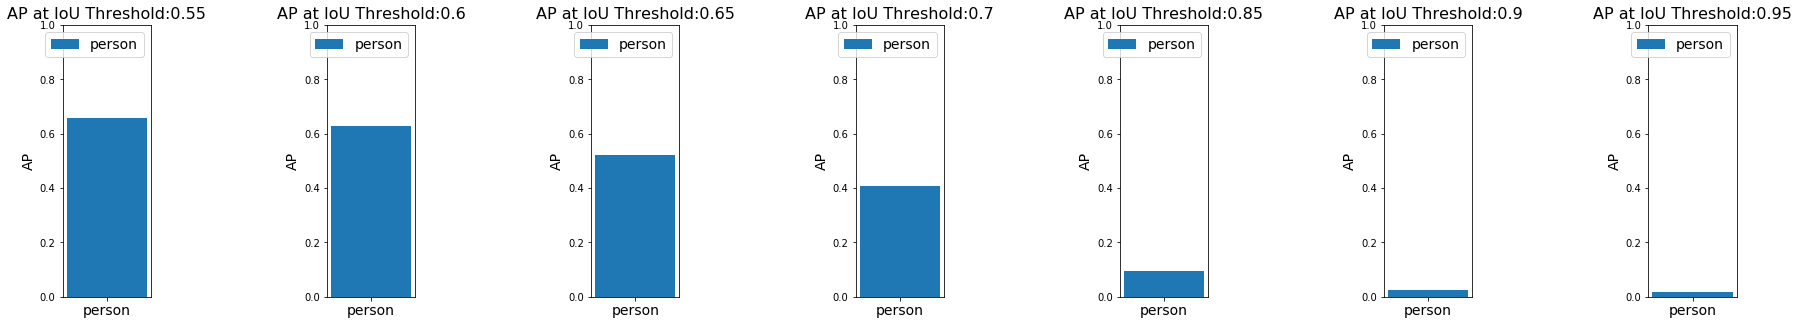

In [35]:
def plot_evaluation(evaluations, classes):
    num_iou = len(evaluations)
    num_classes = len(classes)
    fig,axes = plt.subplots(nrows = 1, ncols = num_iou, figsize=(30,5))
    fig.subplots_adjust(hspace=0.5, wspace=2)
    for ix, evaluation in enumerate(evaluations):
        iou_threshold = evaluations[ix]['IoU Threshold']
        num_classes = len(evaluations[ix]['Class Evaluation'])
        classes_labels = []
        classes_ap = []
        for i in range(0,num_classes):
            classes_labels.append(evaluation['Class Evaluation'][i]['class'])
            classes_ap.append(evaluation['Class Evaluation'][i]['AP'])
        axes[ix].bar(x=classes_labels, height=classes_ap)
        axes[ix].set_title('AP at IoU Threshold:{}'.format(iou_threshold), fontsize=16)
        axes[ix].set_ylabel('AP', fontsize=14)
        axes[ix].tick_params(axis="x", labelsize=14)
        axes[ix].set_ylim(0,1)
        axes[ix].legend(classes_labels, fontsize=14)
    return classes_labels, classes_ap
plot_evaluation(evaluations,['person'])

### Deploy model as Astore file for further scoring in applications (e.g. SAS Event Stream Processing)

In [36]:
yolo_model.save_to_astore('/data/notebooks/deep_learning_examples/Social Distancing Demo/')

NOTE: Model astore file saved successfully.


In [37]:
yolo_model.save_weights_csv('/data/notebooks/deep_learning_examples/Social Distancing Demo/')

NOTE: Model weights csv saved successfully.
